## Initial setup
##### This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
##### This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
##### For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [1]:

'''
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 18 December 2019

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\angel\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [2]:
from ema_workbench import load_results

results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-17-wo-month-data-fixed.tar.gz')


In [3]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [4]:
experiments

,annualCpi,annualInflation,capacityFactorChangeBrownCoal,capacityFactorChangeWater,consumption,distributionUsageChange,energyEfficiency,generationRolloutPeriod,generatorRetirement,includePublicallyAnnouncedGen,...,priceChangePercentageWind,retailUsageChange,rooftopPV,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,technologicalImprovement,scenario,policy,model
0,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,0,Gr4sp
1,0.048008,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,1,Gr4sp
2,0.018789,0.031602,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,2,Gr4sp
3,0.018789,0.013867,1.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,3,Gr4sp
4,0.018789,0.013867,0.0,8.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,4,Gr4sp
5,0.018789,0.013867,0.0,3.0,Central,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,5,Gr4sp
6,0.018789,0.013867,0.0,3.0,Slow change,9.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,6,Gr4sp
7,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,7,Gr4sp
8,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,3.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,8,Gr4sp
9,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,-4.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,9,Gr4sp


##### The outcomes are shown in year. Though another analysis cadone for monthly outcomes. 
##### In total, there are 33 levers. These are listed below.

In [5]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# numActorsYear
outcomes_to_show = ['GHGYear','wholesalePriceYear', 'tariffsYear','primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'rooftopPVProductionYear' ]

# 22 levers selected after EET
levers = ['consumption', 'energyEfficiency', 'rooftopPV', 'solarUptake','annualCpi','annualInflation',
          'includePublicallyAnnouncedGen','generationRolloutPeriod','generatorRetirement','technologicalImprovement',
          'priceChangePercentageBrownCoal','priceChangePercentageWind','priceChangePercentageWater','capacityFactorChangeBrownCoal','capacityFactorChangeWater',
          'distributionUsageChange','retailUsageChange',
          'semiScheduleGenSpotMarket','semiScheduleMinCapMarketGen', 'nonScheduleGenSpotMarket', 'nonScheduleMinCapMarketGen', 
          'learningCurve' ]

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

## SOBOL
##### To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [6]:
from gr4spModelSOBOL import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModel()
leversCategories = determine_parameters(model, 'levers', union=False) 
problem = get_SALib_problem(leversCategories)

# Build input values as floats used for each lever to generate outcomes. Recover them from experiments variable
X = None
for l in levers:
    col_cat = None
    # map category to an index
    if isinstance(model.levers[l], CategoricalParameter):
        col_cat = [ float(model.levers[l].index_for_cat(cat)) for cat in experiments[l] ]
    else:
        col_cat = [ float(cat) for cat in experiments[l] ]
    
    # Concatenate each lever
    if X is None:
        X=col_cat
    else:
        X = np.column_stack((X,col_cat))



In [9]:
t=20
dataY = outcomes['GHGYear'][:, t]
stdY = dataY.std()
meanY = dataY.mean()
nanIdx = np.argwhere(np.isnan(dataY))
print("{} - std: {} - mean: {}".format(startYear+t, stdY, meanY ) )
print(experiments.loc[25])

2018 - std: nan - mean: nan
annualCpi                           0.0480078
annualInflation                     0.0316016
capacityFactorChangeBrownCoal               0
capacityFactorChangeWater                   8
consumption                           Central
distributionUsageChange                     9
energyEfficiency                      Central
generationRolloutPeriod                     3
generatorRetirement                        -4
includePublicallyAnnouncedGen           False
learningCurve                       0.0147949
nonScheduleGenSpotMarket            secondary
nonScheduleMinCapMarketGen            12.0462
priceChangePercentageBrownCoal             16
priceChangePercentageWater                 20
priceChangePercentageWind                  19
retailUsageChange                          -4
rooftopPV                         residential
semiScheduleGenSpotMarket           secondary
semiScheduleMinCapMarketGen             7.721
solarUptake                       Step change
techno

In [15]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_levers = len(levers)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=levers)
    s1_years = pd.DataFrame([],columns=levers)
    s2_years = pd.DataFrame([],columns=levers)
    s2_conf_years = pd.DataFrame([],columns=levers)
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_levels = p to do the analysis with p levels
        stdY = dataY.std()
        
        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_levers )
            sobol_indices['ST_conf'] = np.zeros( num_levers )
            sobol_indices['S1'] = np.zeros( num_levers )
            sobol_indices['S1_conf'] = np.zeros( num_levers )
            sobol_indices['S2'] = np.zeros( (num_levers, num_levers) )
            sobol_indices['S2_conf'] = np.zeros( (num_levers, num_levers) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=levers)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=levers)
        s2 = pd.DataFrame(sobol_indices['S2'], index=levers, columns=levers)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=levers)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s2_years = s2_years.append(s2, sort=False)
        s2_conf_years = s2_conf_years.append(s2_conf, sort=False)
        print("{} - std: {}".format(startYear+t, stdY ) )
        
    s1_years = s1_years.set_index(time)
    # s2_years = s2_years.set_index(time)
    # s2_conf_years = s2_conf_years.set_index(time)
    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    # s2_years_ooi[ooi] = s2_years
    # s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    break
    # 
    # plt_mu_star_years = mu_star_years.plot.line(title=ooi+' - mu_star', figsize=(30, 20))
    # plt_sigma_years = sigma_years.plot.line(title=ooi + ' - sigma', figsize=(30, 20))
    # 
    # plt_mu_star_years.get_figure().savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_mu_star_years_%s'%(ooi)), 
    #                  dpi=300, bbox_inches='tight')
    # plt_sigma_years.get_figure().savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_sigma_years_%s'%(ooi)), 
    #                  dpi=300, bbox_inches='tight')    


1998 - std: 8.881784197001252e-16
1999 - std: 0.600004826792636
2000 - std: 0.5790711615746029
2001 - std: 0.5975105486162646
2002 - std: 0.622105048567288
2003 - std: 0.615647004650865
2004 - std: 0.618943915106078
2005 - std: 0.6192765725820666
2006 - std: 0.6149497817561066
2007 - std: 0.6146275596266738
2008 - std: 0.6272919398585972
2009 - std: 0.6714193168037377
2010 - std: 0.7716452976992211
2011 - std: 0.8223950039544287
2012 - std: 0.8738293003999473
2013 - std: 0.9336634117664393
2014 - std: 0.9810221879798324
2015 - std: 1.0360351191953963
2016 - std: 1.0834223740728524
2017 - std: 0.9010547918037934
2018 - std: nan
2019 - std: 0.9882486961838836
2020 - std: 1.0142599521094486
2021 - std: nan
2022 - std: nan
2023 - std: nan
2024 - std: nan
2025 - std: nan
2026 - std: nan
2027 - std: nan
2028 - std: nan
2029 - std: nan
2030 - std: nan
2031 - std: nan
2032 - std: nan
2033 - std: nan
2034 - std: nan
2035 - std: nan
GHGYear


In [19]:
import matplotlib.ticker as ticker


for ooi in outcomes_to_show:
    mu_star_years = mu_star_years_ooi[ooi]
    for t in range(startYearShift, startYearShift + len(time)):            
        mu_star = pd.DataFrame([mu_star_years.iloc[t]],columns=levers).T  
        mu_star.columns = ['mu_star']
        mu_star = mu_star.sort_values(by='mu_star', ascending=False)
        # mu_star['num_index'] = np.arange(len(problem['names']))
        year = mu_star_years.index[t]
        print(ooi + ' - year ' + str(year))
        print(mu_star[:5])
        
        
        # 
        # f = plt.figure(figsize=(30,20))    
        # chart = sns.barplot(
        #     data=mu_star,
        #     x=mu_star.index,
        #     y='mu_star'
        # 
        # )
        # xlabels = chart.get_xticklabels()        
        # chart.set_xticklabels(xlabels, rotation=90)
        # f.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_mu_star_year_%d_%s'%(year,ooi)), 
        #                     dpi=300, bbox_inches='tight')
        # 
        # f.clear()
        # plt.close(f)

KeyError: 'GHGYear'

In [20]:
#Save mu_star into EXCEL
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp', '_mu_star'), engine='xlsxwriter')
for ooi in outcomes_to_show:
    mu_star_years = mu_star_years_ooi[ooi]
    mu_star_years.to_excel(writer, sheet_name=ooi)
writer.save()

#Save sigma into EXCEL
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp', '_sigma'), engine='xlsxwriter')
for ooi in outcomes_to_show:
    sigma_years = sigma_years_ooi[ooi]
    sigma_years.to_excel(writer, sheet_name=ooi)
writer.save()

KeyError: 'GHGYear'

### Average mu_star and sigma all years in data frame

In [24]:
mu_star_average_ooi = {}
mu_star_max_val_ooi = {}
sigma_average_ooi = {}
sigma_max_val_ooi = {}

for ooi in outcomes_to_show:
    
    mu_star_average_ooi[ooi] = mu_star_years_ooi[ooi].mean()    
    mu_star_max_val_ooi[ooi] = mu_star_years_ooi[ooi].max()
    sigma_average_ooi[ooi] = sigma_years_ooi[ooi].mean()
    sigma_max_val_ooi[ooi] = sigma_years_ooi[ooi].max()

### Scatter plots of mu_star vs sigma 

GHGYear
wholesalePriceYear
tariffsYear
primarySpotProductionYear
secondarySpotProductionYear
offSpotProductionYear
rooftopPVProductionYear


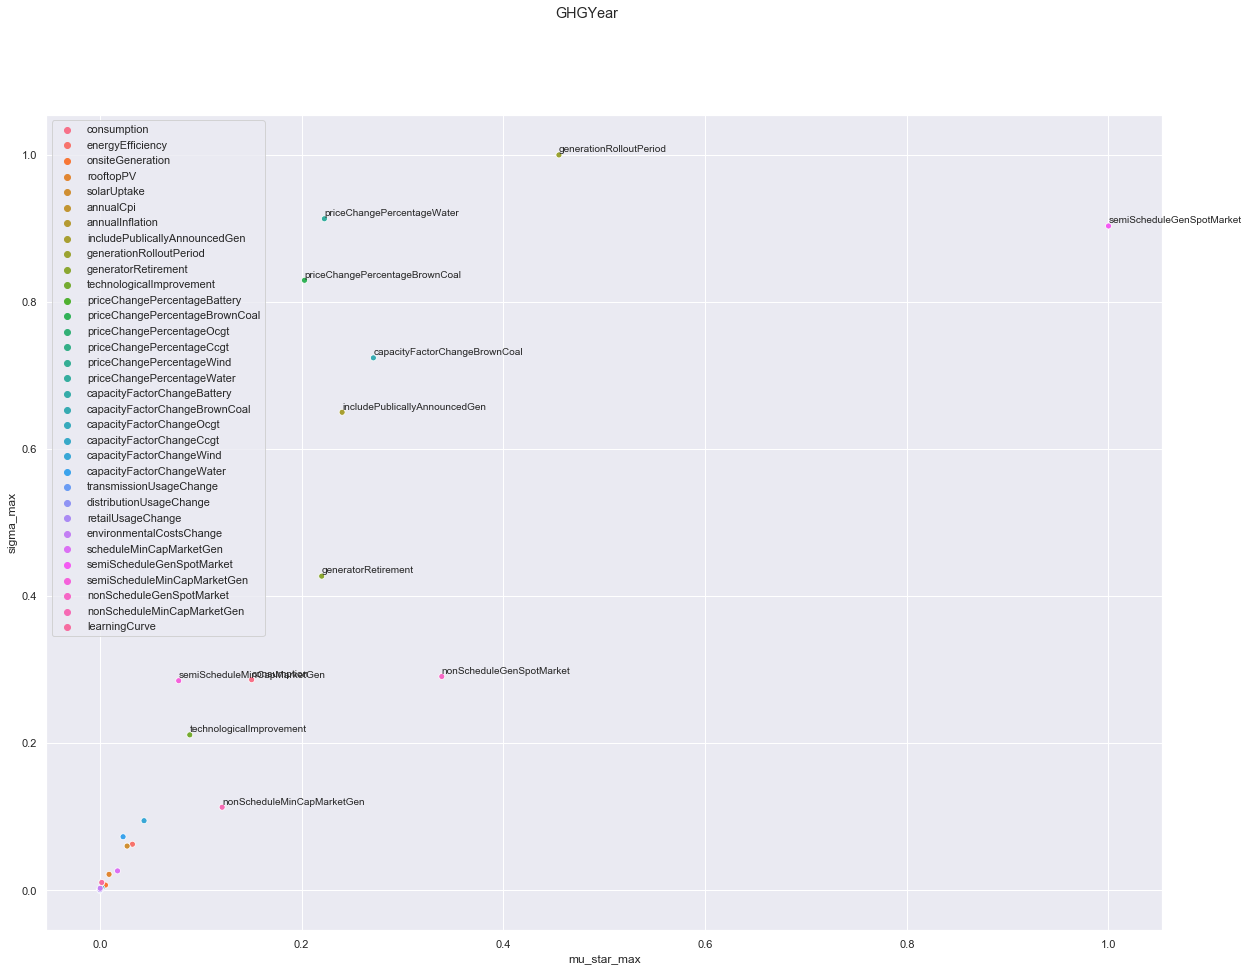

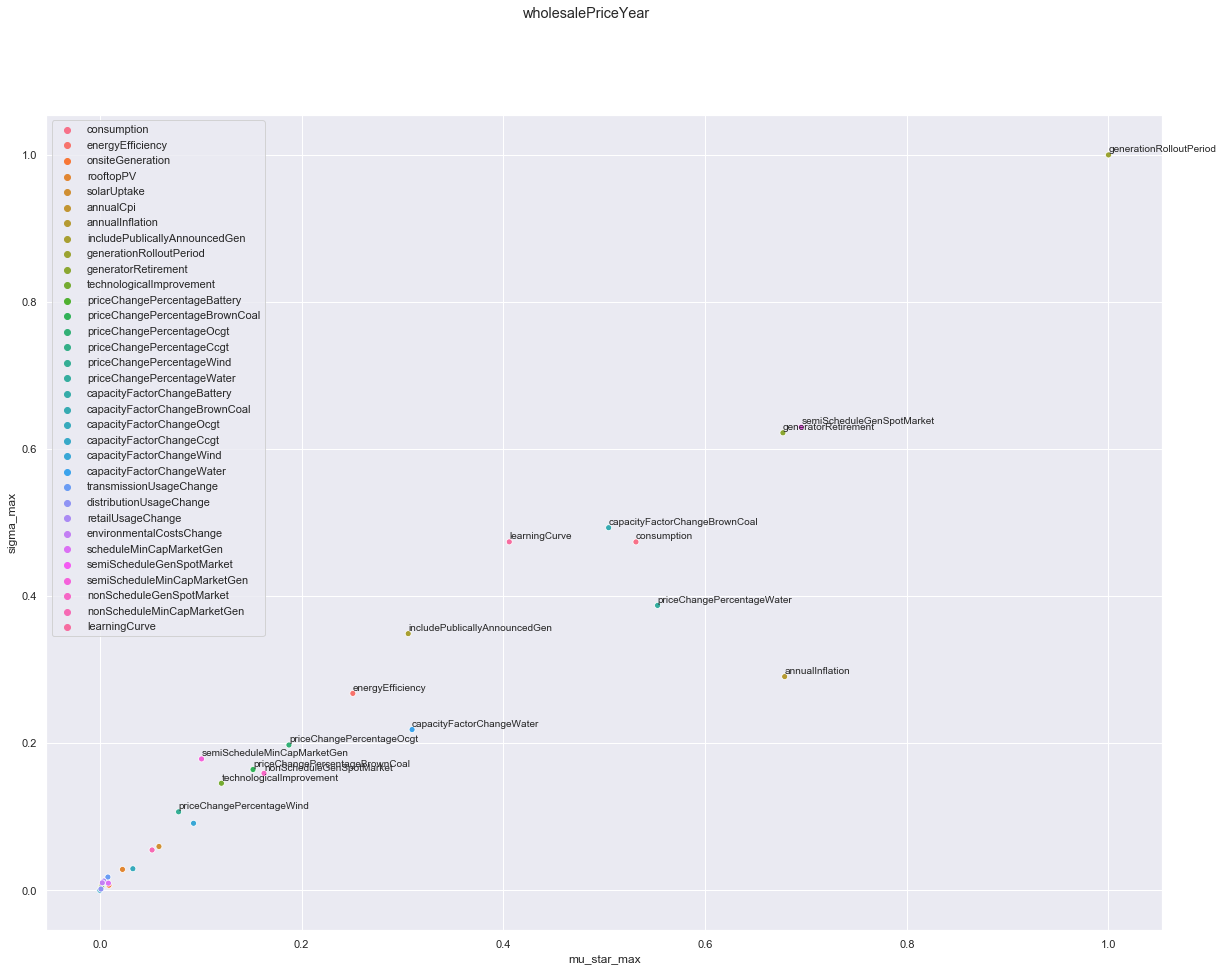

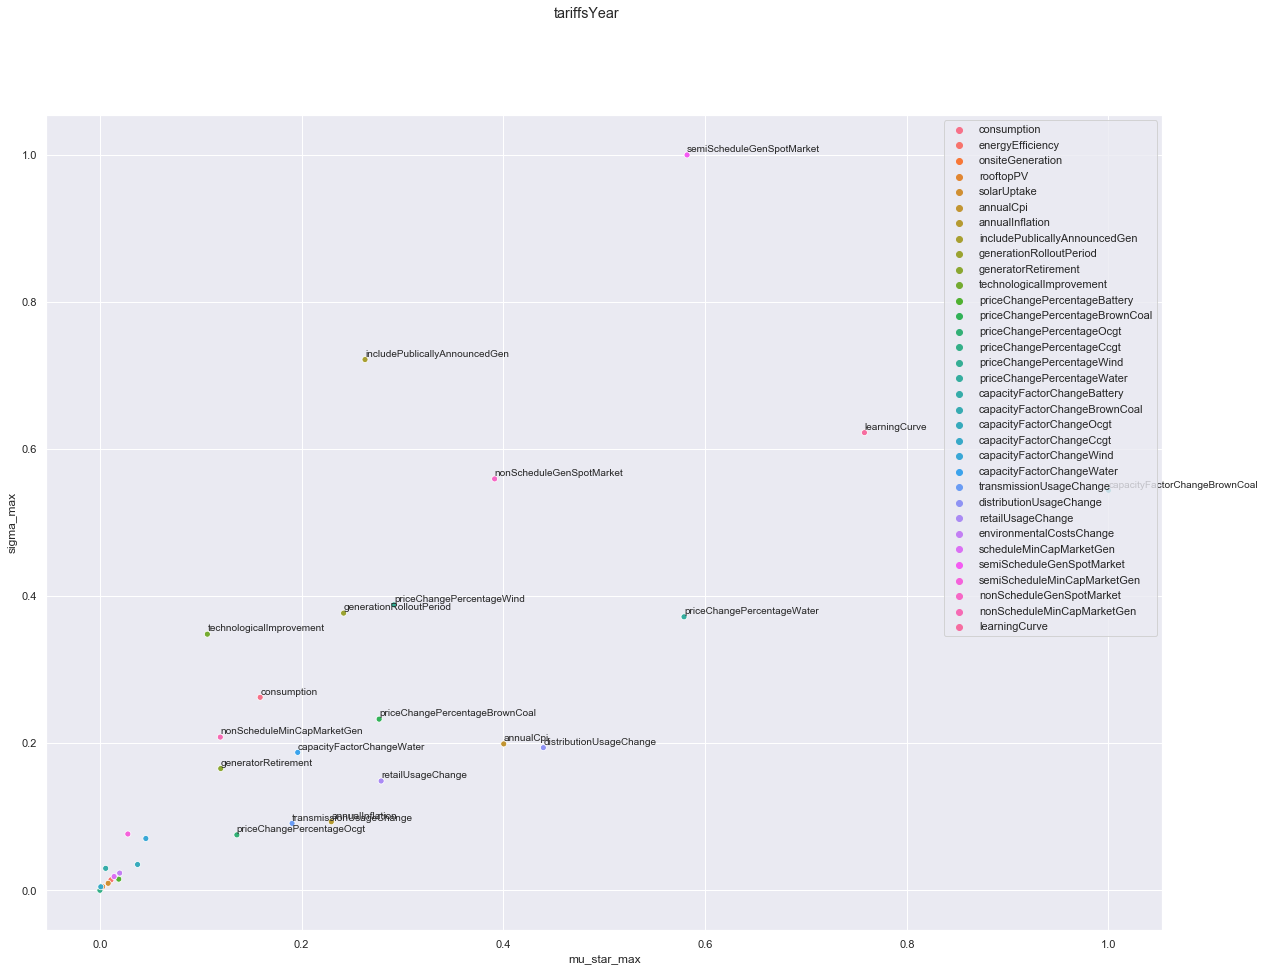

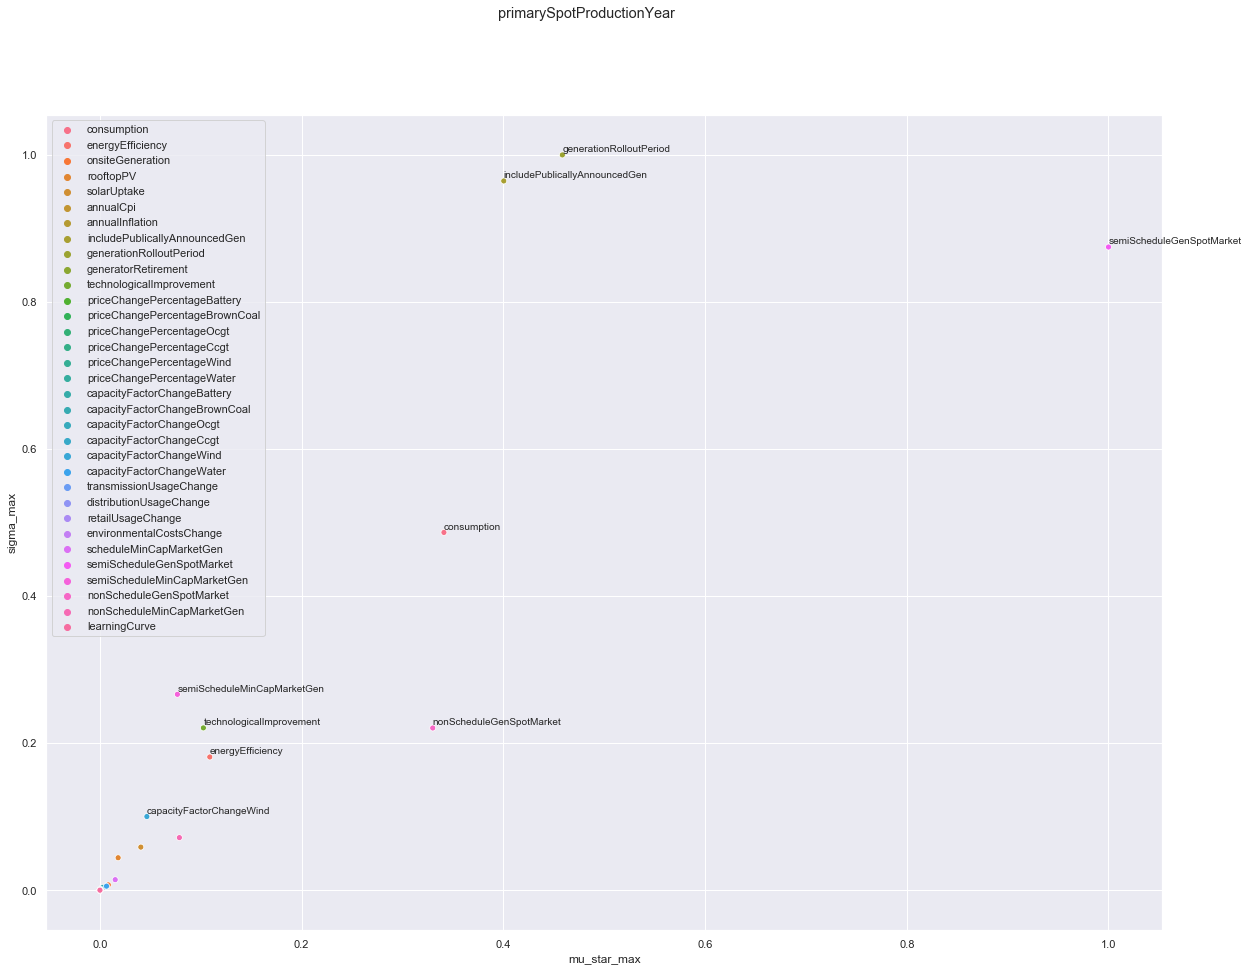

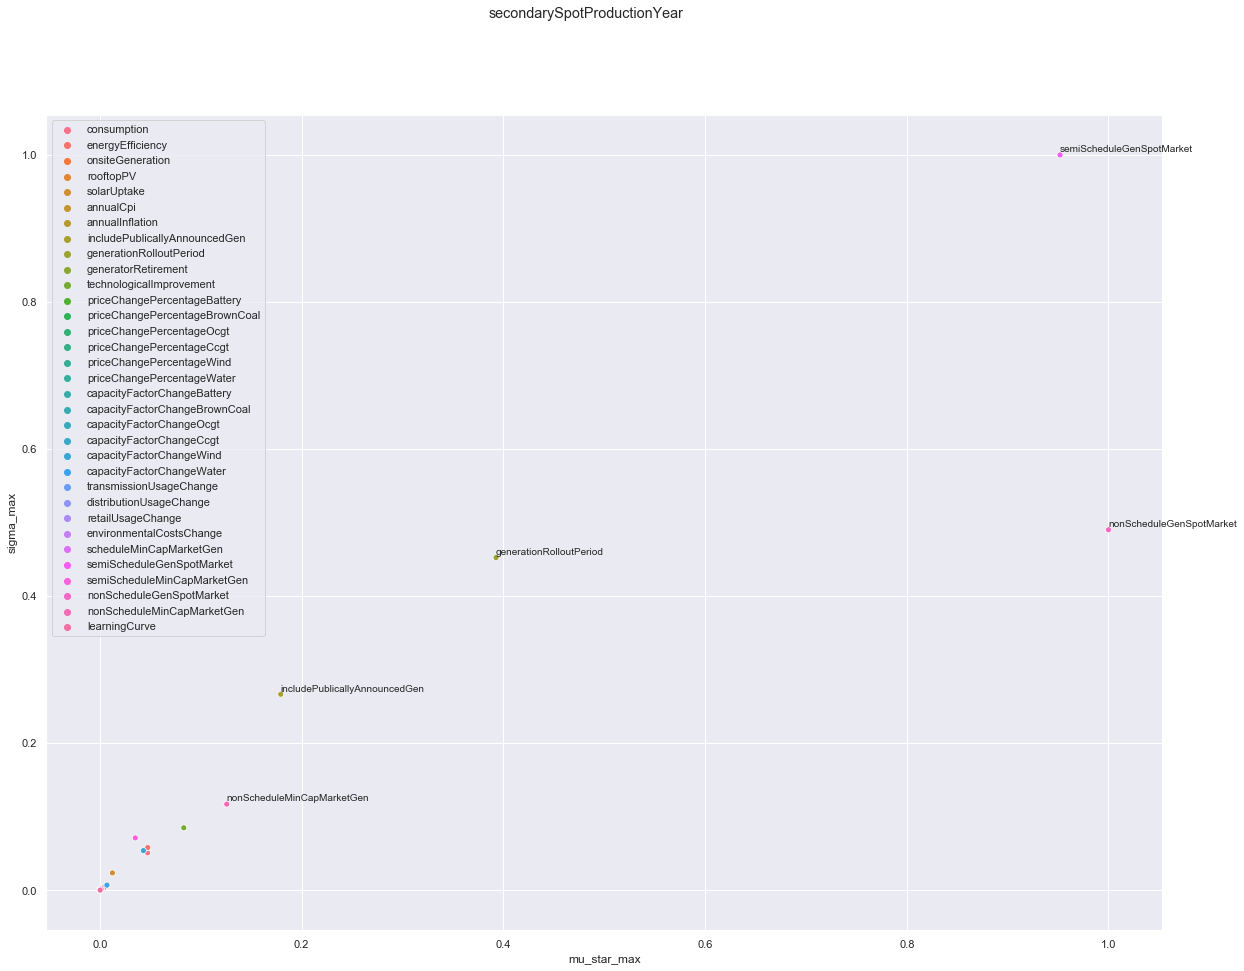

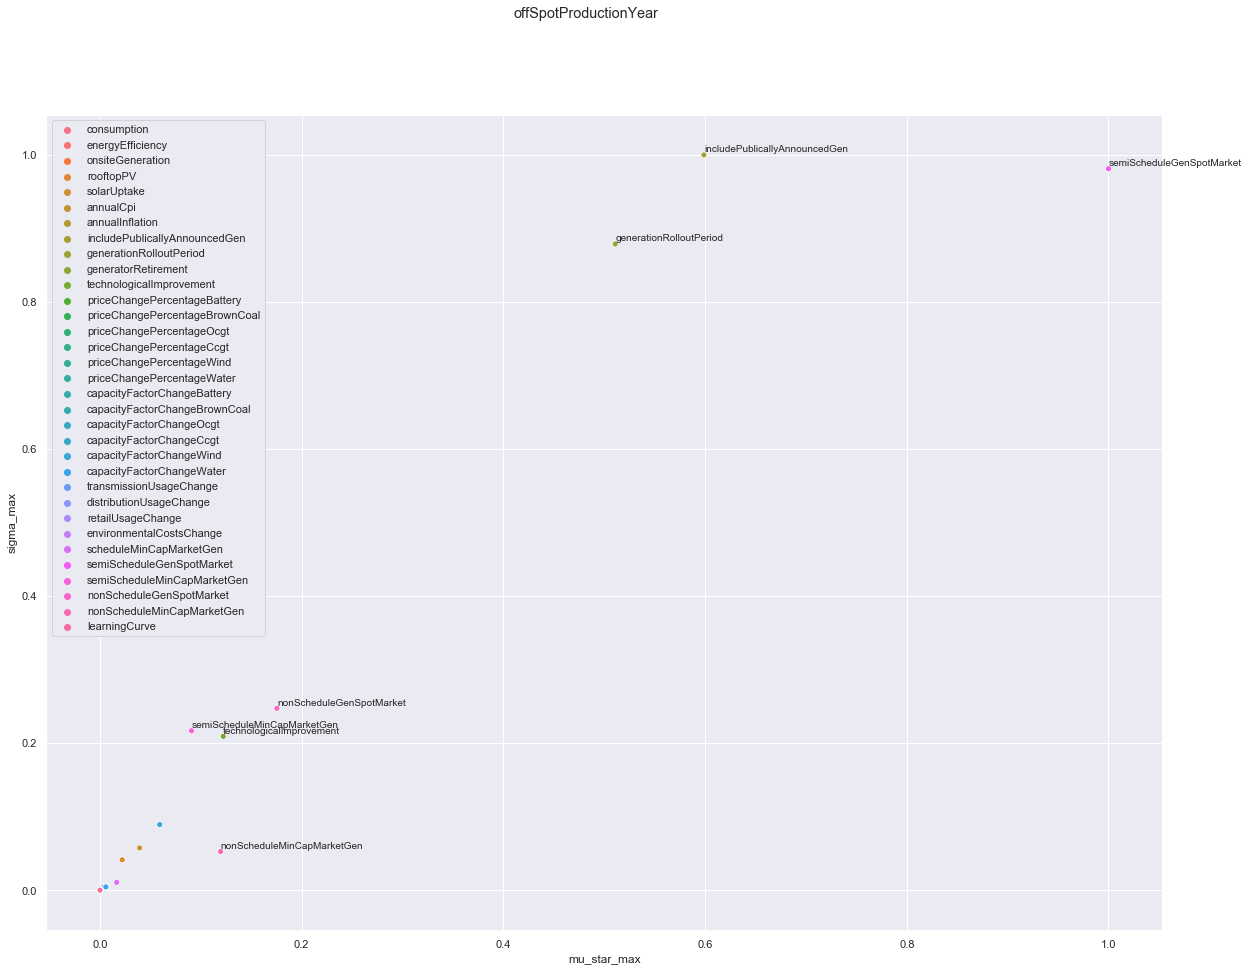

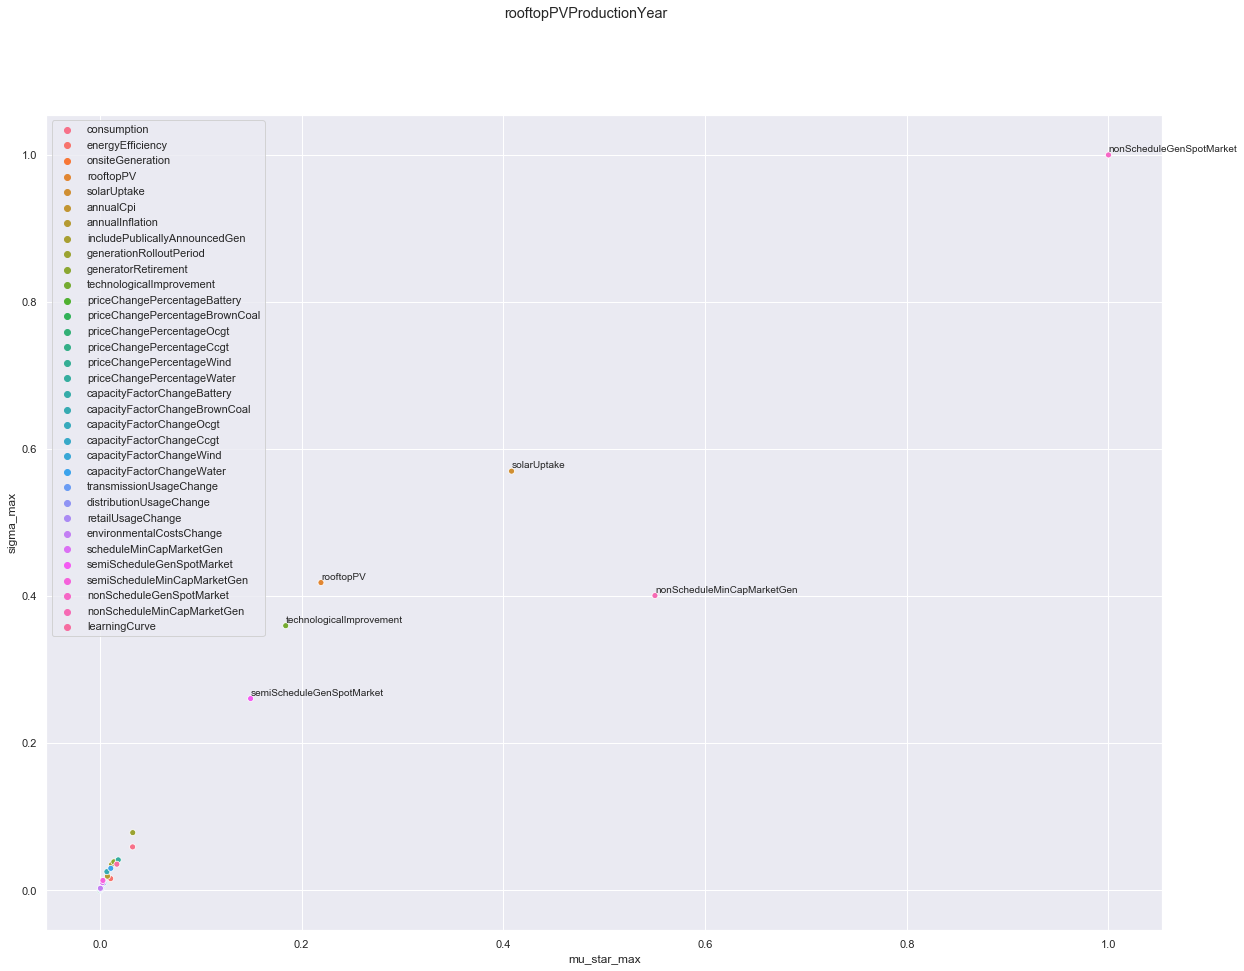

In [25]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 

for ooi in outcomes_to_show:
    
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_max_val_ooi[ooi] - mu_star_max_val_ooi[ooi].min())/(mu_star_max_val_ooi[ooi].max() - mu_star_max_val_ooi[ooi].min())
    normalized_sigma = (sigma_max_val_ooi[ooi] - sigma_max_val_ooi[ooi].min())/(sigma_max_val_ooi[ooi].max() - sigma_max_val_ooi[ooi].min())
    
    df_max = pd.concat({'mu_star_max': normalized_mu_star,'sigma_max': normalized_sigma}, axis=1)
    
    f=plt.figure(figsize=(20,15))
    f.suptitle(ooi)
    
    
    sns.scatterplot(x='mu_star_max',y='sigma_max', hue=df_max.index, data=df_max)
    
    #df_max.plot.scatter(x='mu_star_max',y='sigma_max',c='DarkBlue')
    
    #Add labels above points
    for index, row in df_max.iterrows():
            if row['mu_star_max'] <= 0.1 and row['sigma_max'] <= 0.1: continue
            plt.annotate(index, # this is the text
                         (row['mu_star_max'],row['sigma_max']), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,3), # distance from text to points (x,y)
                         ha='left', # horizontal alignment can be left, right or center
                         fontsize=10)  # font size



    print(ooi)

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', 'scatter_mu_star_sigmna_max_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
# f.show()
# f.clear()
# plt.close(f)

### Subset significant factors
Scatter plots of mu_star vs sigma 

GHGYear - 11
['consumption' 'includePublicallyAnnouncedGen' 'generationRolloutPeriod'
 'generatorRetirement' 'technologicalImprovement'
 'priceChangePercentageBrownCoal' 'priceChangePercentageWater'
 'capacityFactorChangeBrownCoal' 'semiScheduleGenSpotMarket'
 'semiScheduleMinCapMarketGen' 'nonScheduleGenSpotMarket']
wholesalePriceYear - 11
['consumption' 'energyEfficiency' 'annualInflation'
 'includePublicallyAnnouncedGen' 'generationRolloutPeriod'
 'generatorRetirement' 'priceChangePercentageWater'
 'capacityFactorChangeBrownCoal' 'capacityFactorChangeWater'
 'semiScheduleGenSpotMarket' 'learningCurve']
tariffsYear - 16
['consumption' 'annualCpi' 'annualInflation'
 'includePublicallyAnnouncedGen' 'generationRolloutPeriod'
 'technologicalImprovement' 'priceChangePercentageBrownCoal'
 'priceChangePercentageWind' 'priceChangePercentageWater'
 'capacityFactorChangeBrownCoal' 'distributionUsageChange'
 'retailUsageChange' 'semiScheduleGenSpotMarket'
 'nonScheduleGenSpotMarket' 'nonSchedul

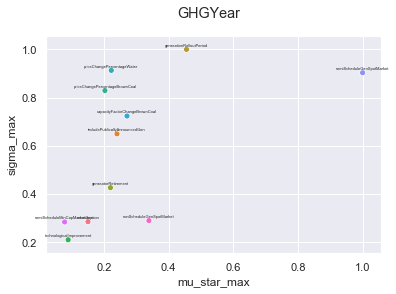

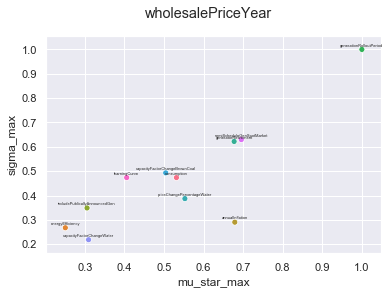

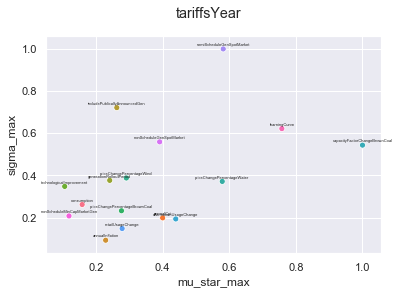

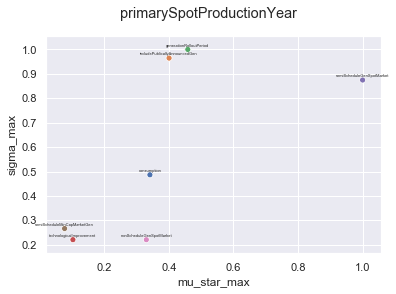

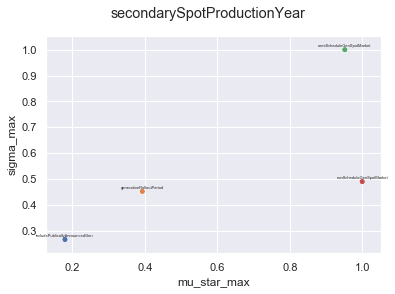

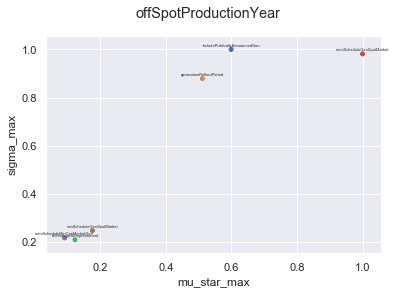

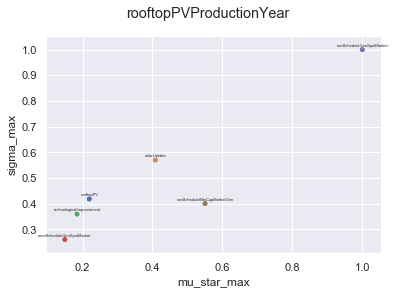

In [26]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 

#bound used to filter INPUTS
significance_bound = 0.2
significant_inputs = set()
significant_inputs_filter = {}
for ooi in outcomes_to_show:
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_max_val_ooi[ooi] - mu_star_max_val_ooi[ooi].min())/(mu_star_max_val_ooi[ooi].max() - mu_star_max_val_ooi[ooi].min())
    normalized_sigma = (sigma_max_val_ooi[ooi] - sigma_max_val_ooi[ooi].min())/(sigma_max_val_ooi[ooi].max() - sigma_max_val_ooi[ooi].min())
    
    #filter values
    filter_mu_star = normalized_mu_star > significance_bound
    filter_sigma = normalized_sigma > significance_bound
    normalized_mu_star_filtered = normalized_mu_star[ filter_mu_star | filter_sigma ]
    normalized_sigma_filtered = normalized_sigma[ filter_mu_star | filter_sigma ] 
    
    #keep track significant inputs filter
    significant_inputs_filter[ooi] = normalized_mu_star_filtered.index.values
    for l in normalized_mu_star_filtered.index.values:
        significant_inputs.add(l) 
    
    #create dataframe     
    df_max = pd.concat({'mu_star_max': normalized_mu_star_filtered,'sigma_max': normalized_sigma_filtered}, axis=1)
    
    #print significant indexes per ooi
    print(ooi + ' - {}'.format(len(significant_inputs_filter[ooi])))
    print(significant_inputs_filter[ooi])
    
    #create figure
    f=plt.figure()#figsize=(30,20))
    f.suptitle(ooi)
    
    #ScatterPlot        
    #df_max.plot.scatter(x='mu_star_max',y='sigma_max',c='DarkBlue')
    sns.scatterplot(x='mu_star_max',y='sigma_max', hue=df_max.index, data=df_max, legend=False)

    
    #Add labels above points
    for index, row in df_max.iterrows():
            plt.annotate(index, # this is the text
                         (row['mu_star_max'],row['sigma_max']), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,3), # distance from text to points (x,y)
                         ha='center', # horizontal alignment can be left, right or center
                         fontsize=4)  # font size
           
        

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', 'scatter_mu_star_sigmna_max_%s_filtered'%(ooi)),dpi=300, bbox_inches='tight')
# f.show()
# f.clear()
# plt.close(f)

print("ALL significant inputs (%d)"%len(significant_inputs))
print(significant_inputs)

In [27]:
normalized_mu_star.index

Index(['consumption', 'energyEfficiency', 'onsiteGeneration', 'rooftopPV',
       'solarUptake', 'annualCpi', 'annualInflation',
       'includePublicallyAnnouncedGen', 'generationRolloutPeriod',
       'generatorRetirement', 'technologicalImprovement',
       'priceChangePercentageBattery', 'priceChangePercentageBrownCoal',
       'priceChangePercentageOcgt', 'priceChangePercentageCcgt',
       'priceChangePercentageWind', 'priceChangePercentageWater',
       'capacityFactorChangeBattery', 'capacityFactorChangeBrownCoal',
       'capacityFactorChangeOcgt', 'capacityFactorChangeCcgt',
       'capacityFactorChangeWind', 'capacityFactorChangeWater',
       'transmissionUsageChange', 'distributionUsageChange',
       'retailUsageChange', 'environmentalCostsChange',
       'scheduleMinCapMarketGen', 'semiScheduleGenSpotMarket',
       'semiScheduleMinCapMarketGen', 'nonScheduleGenSpotMarket',
       'nonScheduleMinCapMarketGen', 'learningCurve'],
      dtype='object')

## Boxplot

In [28]:
for ooi in outcomes_to_show:
    data = outcomes[ooi][:, startYearShift:]
    
    dfBoxPlot = pd.DataFrame(index = index, data = data.T,columns=[ experiments[l] for l in levers])
    dfMeltdfBoxPlot = pd.melt(dfBoxPlot)
    #dfMeltdfBoxPlot.rename(columns={"value":ooi})
    
    for l in levers:
        ax = dfMeltdfBoxPlot.boxplot(by=l, meanline=True, showmeans=False, showcaps=True, 
                        showbox=True, showfliers=False, return_type='axes', figsize=(15, 10))
        
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_boxplots_%s_%s'%(ooi,l)), 
                     dpi=300, bbox_inches='tight')
        
       
        plt.show()
        plt.close()


TypeError: Index(...) must be called with a collection of some kind, 'nonScheduleMinCapMarketGen' was passed

In [15]:
### Changes on different wholesale prices with different policies applied to the consumption lever over time.

In [ ]:
from ema_workbench.analysis.plotting_util import get_color, COLOR_LIST
from ema_workbench.analysis.plotting import lines

experiments, outcomes = results

startYear = 2019 
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1998) * 12

ooi = 'wholesalePriceYear'

data = outcomes[ooi]

consumption_list = ['Central', 'Slow change', 'Fast change', 'Step change', 'High DER']

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)
df_concat = pd.concat([exp, out], axis=1)

time = outcomes['TIMEYear'][0, startYearShift:]
index = pd.to_datetime(time, format = '%Y')
#index = pd.to_datetime(time, format = '%Y-%m-%d')


f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments['consumption'].str.count("High DER").sum() ):
    
    truncated_outcomes_0 = out[exp['consumption'] == "High DER"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_0, color = 'red')

for i in range( experiments.consumption.str.count("Central").sum() ):    
    truncated_outcomes_1 = out[exp['consumption'] == "Central"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.consumption.str.count("Slow change").sum() ):
    truncated_outcomes_2 = out[exp['consumption'] == "Slow change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')

for i in range( experiments.consumption.str.count("Fast change").sum() ):
    truncated_outcomes_3 = out[exp['consumption'] == "Fast change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_3, color = 'green')

for i in range( experiments.consumption.str.count("Step change").sum() ):
    truncated_outcomes_4 = out[exp['consumption'] == "Step change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_4, color = 'orange')

ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
#leg = ax.legend();
               
        
plt.show()


In [7]:
exp_sorted = exp.sort_values(['consumption', 'energyEfficiency', 'onsiteGeneration', 'rooftopPV', 'solarUptake']).set_index(['consumption', 'energyEfficiency', 'onsiteGeneration', 'rooftopPV', 'solarUptake' ])
exp_sorted.head()


NameError: name 'exp' is not defined

### Changes on wholesale prices from different policies applied to the onsiteGeneration lever over time.

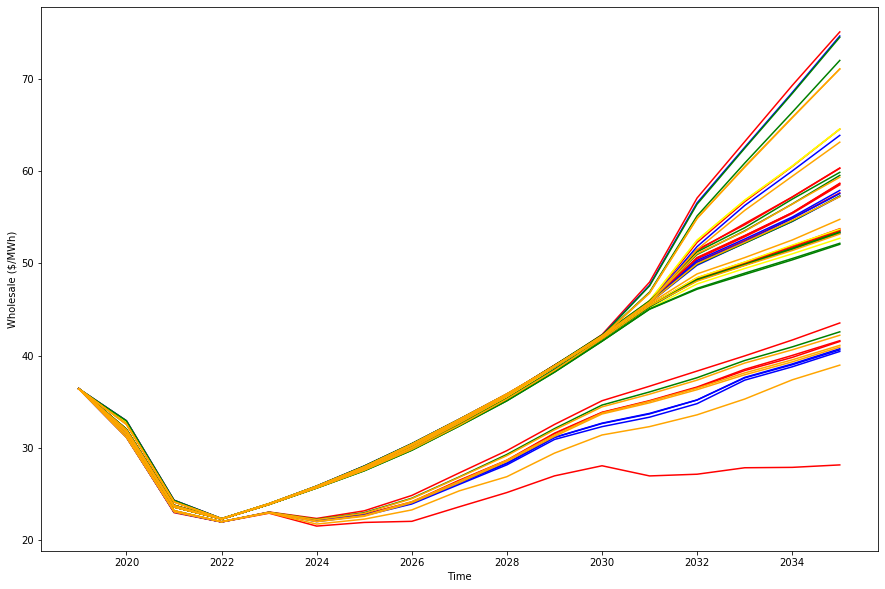

In [18]:

f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments.onsiteGeneration.str.count("High DER").sum() ):
    
    truncated_outcomes_0 = out[exp['onsiteGeneration'] == "High DER"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_0, color = 'red')

for i in range( experiments.onsiteGeneration.str.count("Central").sum() ):    
    truncated_outcomes_1 = out[exp['onsiteGeneration'] == "Central"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.onsiteGeneration.str.count("Slow change").sum() ):
    truncated_outcomes_2 = out[exp['onsiteGeneration'] == "Slow change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')

for i in range( experiments.onsiteGeneration.str.count("Fast change").sum() ):
    truncated_outcomes_3 = out[exp['onsiteGeneration'] == "Fast change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_3, color = 'green')

for i in range( experiments.onsiteGeneration.str.count("Step change").sum() ):
    truncated_outcomes_4 = out[exp['onsiteGeneration'] == "Step change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_4, color = 'orange')

ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
               
plt.show()



### Changes on wholesale prices from different policies applied to the energyEffciency lever over time.

NameError: name 'out' is not defined

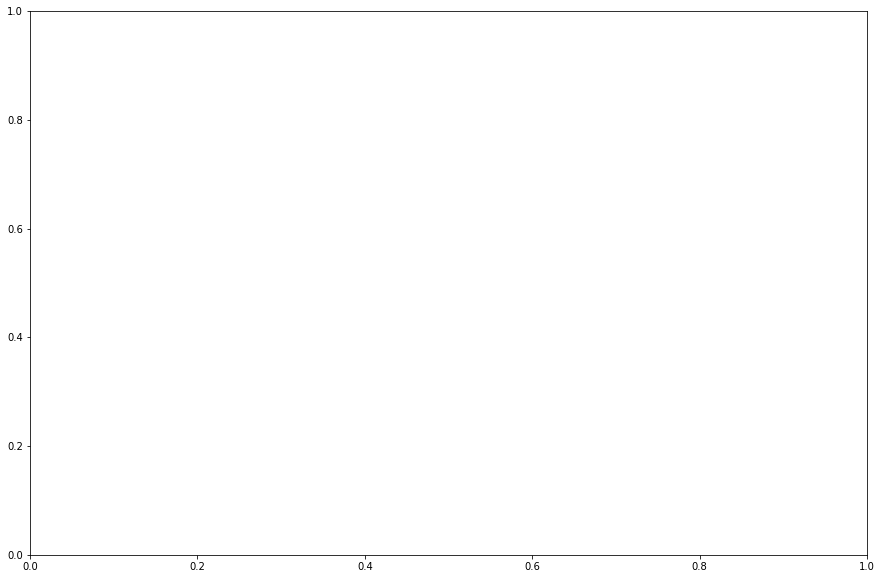

In [8]:

f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments.energyEfficiency.str.count("Central").sum() ):    
    truncated_outcomes_1 = out[exp['energyEfficiency'] == "Central"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.energyEfficiency.str.count("Slow change").sum() ):
    truncated_outcomes_2 = out[exp['energyEfficiency'] == "Slow change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')

for i in range( experiments.energyEfficiency.str.count("Step change").sum() ):
    truncated_outcomes_4 = out[exp['energyEfficiency'] == "Step change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_4, color = 'orange')

ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
               
plt.show()



### Changes on wholesale prices from different policies applied to the rooftopPV lever over time.

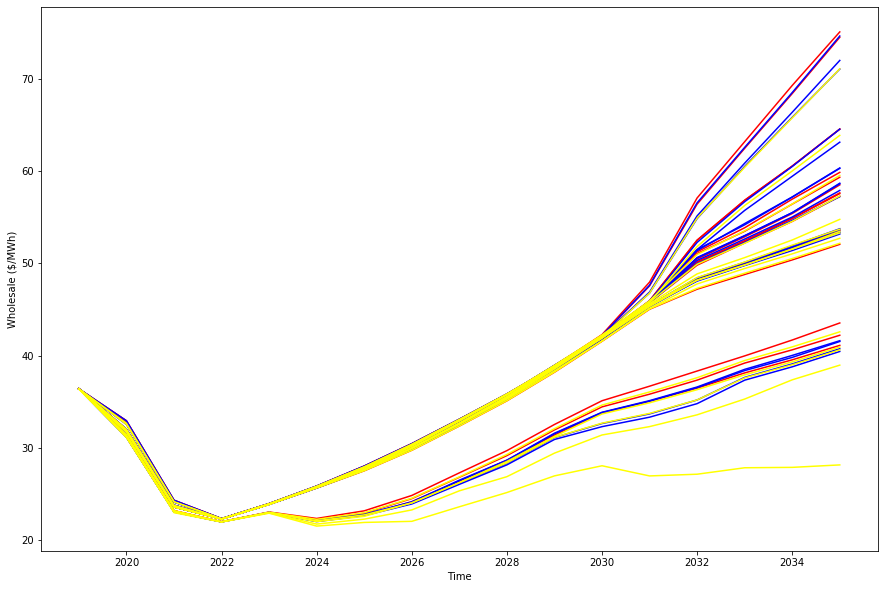

In [20]:

f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments.rooftopPV.str.count("residential").sum() ):
    
    truncated_outcomes_0 = out[exp['rooftopPV'] == "residential"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_0, color = 'red')

for i in range( experiments.rooftopPV.str.count("business").sum() ):    
    truncated_outcomes_1 = out[exp['rooftopPV'] == "business"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.rooftopPV.str.count("both").sum() ):
    truncated_outcomes_2 = out[exp['rooftopPV'] == "both"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')


ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
               
plt.show()


### Changes on wholesale prices from different policies applied to the solarUptake lever over time.

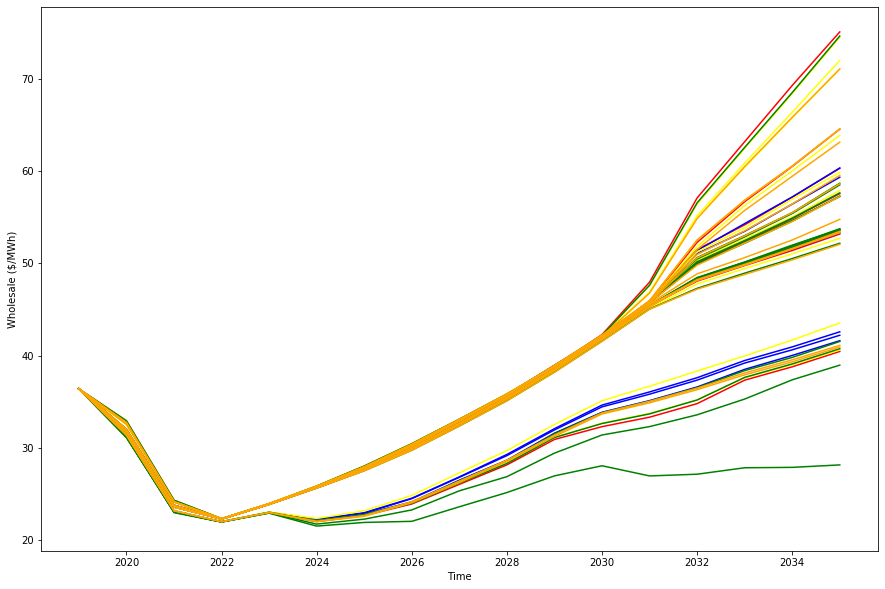

In [21]:

f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments.solarUptake.str.count("High DER").sum() ):
    
    truncated_outcomes_0 = out[exp['solarUptake'] == "High DER"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_0, color = 'red')

for i in range( experiments.solarUptake.str.count("Central").sum() ):    
    truncated_outcomes_1 = out[exp['solarUptake'] == "Central"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.solarUptake.str.count("Slow change").sum() ):
    truncated_outcomes_2 = out[exp['solarUptake'] == "Slow change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')

for i in range( experiments.solarUptake.str.count("Fast change").sum() ):
    truncated_outcomes_3 = out[exp['solarUptake'] == "Fast change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_3, color = 'green')

for i in range( experiments.solarUptake.str.count("Step change").sum() ):
    truncated_outcomes_4 = out[exp['solarUptake'] == "Step change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_4, color = 'orange')

ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
               
plt.show()



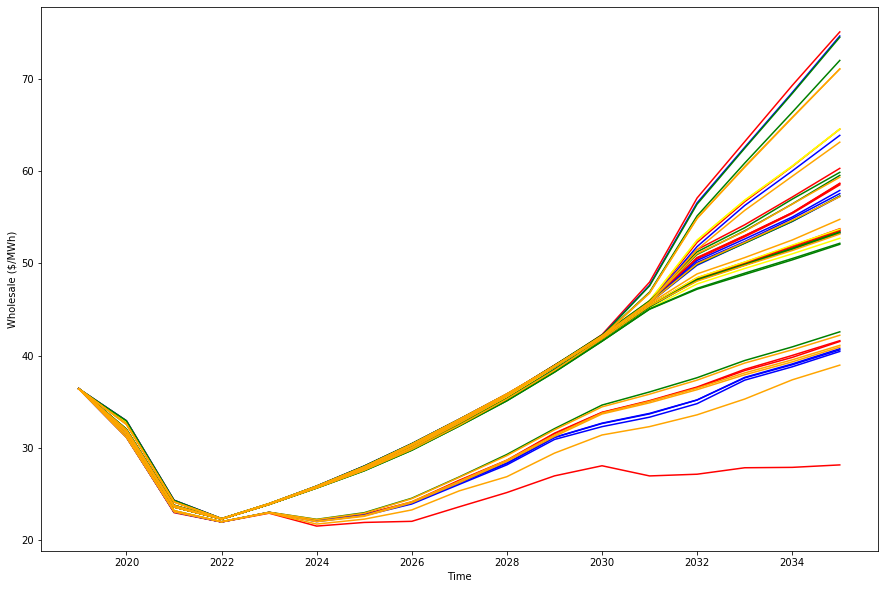

In [22]:
f, ax = plt.subplots(figsize=(15, 10))  

for i in range( experiments.consumption.str.count("High DER").sum() ):
    
    truncated_outcomes_0 = out[exp['onsiteGeneration'] == "High DER"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_0, color = 'red')

for i in range( experiments.onsiteGeneration.str.count("Central").sum() ):    
    truncated_outcomes_1 = out[exp['onsiteGeneration'] == "Central"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_1, color = 'blue')

for i in range( experiments.onsiteGeneration.str.count("Slow change").sum() ):
    truncated_outcomes_2 = out[exp['onsiteGeneration'] == "Slow change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_2, color = 'yellow')

for i in range( experiments.onsiteGeneration.str.count("Fast change").sum() ):
    truncated_outcomes_3 = out[exp['onsiteGeneration'] == "Fast change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_3, color = 'green')

for i in range( experiments.onsiteGeneration.str.count("Step change").sum() ):
    truncated_outcomes_4 = out[exp['onsiteGeneration'] == "Step change"].values[i, startYearShift:]
    sns.lineplot(x=index, y=truncated_outcomes_4, color = 'orange')

ax.set_xlabel ("Time")
ax.set_ylabel ("Wholesale ($/MWh)")
               
plt.show()


In [23]:
### Group by policies 

In [24]:


experiments, outcomes = results

ooi = 'wholesalePriceYear'
data = outcomes[ooi] 

# # tech_list = ['Central', 'ICE', 'carshare', 'publictransport'] 
# # time_list = [10, 20, 30, 40, 49]  
# 
# exp = pd.DataFrame(experiments)
# out = pd.DataFrame(data)
# 
# ooi_results=[]
# df_kde_list=[]
# 
# for time in time_list:
#     for i, tech in enumerate(tech_list):        
#         truncated_outcomes = out[exp['policy'] == tech].values
#         size = len(truncated_outcomes[:,time])
#         df_kde_list.append(pd.DataFrame({'Share_of_supporter': truncated_outcomes[:, time].tolist(),
#                                    'Technology':[tech]*size}, index=range(size)))
#         
#     df_kde=pd.concat(df_kde_list[i] for i in range(len(tech_list)))
#     ooi_results.append(df_kde)
#     
# df_kde.Share_of_supporter
        
#ooi_results[2].Share_of_supporter[ooi_results[2].Technology == 'publictransport']

In [25]:
time

array([2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035], dtype=int64)

In [26]:
outcomes['wholesalePriceYear']

array([[ 0.        , 25.14046462, 35.94871298, ..., 63.20292091,
        69.29753621, 75.10024675],
       [ 0.        , 25.14046462, 35.94871298, ..., 60.42221737,
        65.78538958, 71.09491984],
       [ 0.        , 25.14046462, 35.94871298, ..., 50.62895521,
        52.53796069, 54.7739261 ],
       ...,
       [ 0.        , 25.14046462, 35.94871298, ..., 62.48359966,
        68.41684405, 74.51963838],
       [ 0.        , 25.14046462, 35.94871298, ..., 52.28269831,
        54.66809718, 57.23823802],
       [ 0.        , 25.14046462, 35.94871298, ..., 60.51276334,
        65.84073385, 71.07269637]])

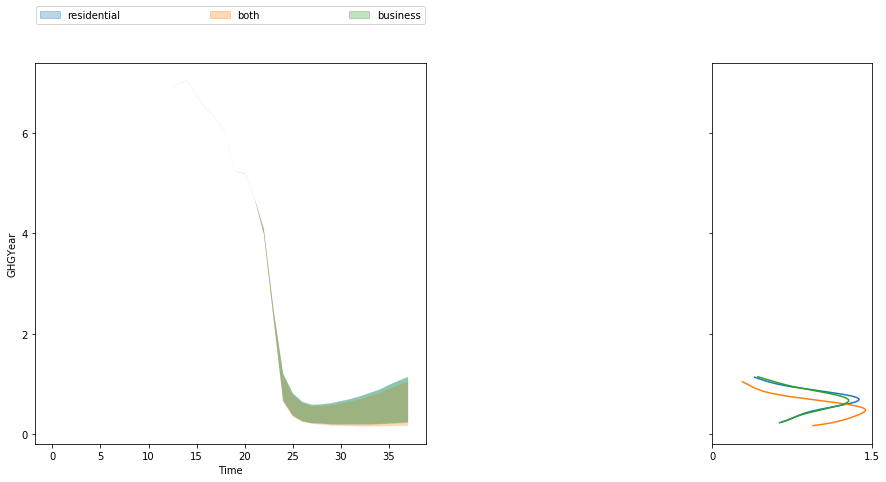

In [27]:
%matplotlib inline

from ema_workbench.analysis.plotting import envelopes
from ema_workbench.analysis.plotting_util import Density 


grid = plt.GridSpec(1, 6, wspace=0.2, hspace=0.3, width_ratios=[60,10,10,10,10,10])

#Create envelope plot
ooi = 'GHGYear'

# group_by='rooftopPV', density = Density.KDE, grouping_specifiers={'residential', 'business', 'both'}
# group_by='onsiteGeneration', density = Density.KDE, grouping_specifiers={'Central', 'Slow change', 'Fast change', 'Step change', 'High DER'}

ax_env = envelopes(experiments, outcomesYear, outcomes_to_show = ooi, group_by='rooftopPV', density = Density.KDE, grouping_specifiers={'residential', 'business', 'both'} , 
                   titles={ooi},
          ylabels={ooi: ooi}, legend=True, fill=True)

#Assign created plot to the grid space        
ax_env[1][ooi].set_position(grid[0].get_position(ax_env[0]))

# data = outcomes[ooi] 

# #tech_list = ['hybrid', 'ICE', 'bev', 'publictransport', 'carshare', 'slowmodes'] 
# consumption_list = ['Central', 'Slow change', 'Fast change', 'Step change', 'High DER']
# time_list = [0, int(time.size/4), int(time.size/2), int(time.size/1.5) ,time.size - 1]  

# exp = pd.DataFrame(experiments)
# out = pd.DataFrame(data)

# ooi_results=[]

# for t in time_list:
#     df_kde_list=[]
#     for i, consumption in enumerate(consumption_list):        
#         truncated_outcomes = out[exp['consumption'] == consumption].values
#         #print (time_list, consumption, t, len(truncated_outcomes[0,:]), len(truncated_outcomes[1,:]) )        
#         size = len(truncated_outcomes[:,t])
#         df_kde_list.append(pd.DataFrame({'Share_of_wholesale': truncated_outcomes[:, t].tolist(),
#                                    'Consumption':[consumption]*size}, index=range(size)))
        
#     df_kde=pd.concat(df_kde_list[i] for i in range(len(consumption_list)))
#     ooi_results.append(df_kde)
    


# #create and assign KDEs with shared axis to grid cells
# ax_kde = []
# ax_kde.append(plt.subplot(grid[1]))
# for i, val in enumerate([2,3,4,5]): 
#     ax_kde.append(plt.subplot(grid[val], sharey=ax_kde[0]))
#     ax_kde[i+1].set_yticklabels([])
#     ax_kde[i+1].set_ylim([0, 1])
    
    
    
# # for j, val in enumerate(time_list):
# #     sns.kdeplot(ooi_results[j].Share_of_wholesale[ooi_results[j].Consumption == 'Central'],
# #                 label='Central', color='goldenrod', legend=False, vertical=True, ax=ax_kde[j])
# #     sns.kdeplot(ooi_results[j].Share_of_wholesale[ooi_results[j].Consumption == 'Slow change'],
# #                 label='SlowChange', color='green', legend=False, vertical=True, ax=ax_kde[j])
# #     sns.kdeplot(ooi_results[j].Share_of_wholesale[ooi_results[j].Consumption == 'Step change'],
# #                 label='StepChange', color='mediumpurple', legend=False, vertical=True, ax=ax_kde[j])
# #     sns.kdeplot(ooi_results[j].Share_of_wholesale[ooi_results[j].Consumption == 'Fast change'],
# #                 label='FastChange', color='hotpink', legend=False, vertical=True, ax=ax_kde[j])
# #     sns.kdeplot(ooi_results[j].Share_of_wholesale[ooi_results[j].Consumption == 'High DER'],
# #                 label='HighDER', color='lightskyblue', legend=False, vertical=True, ax=ax_kde[j])
# #     ax_kde[j].annotate('Timestep=' + str(val) , xycoords='axes fraction' , textcoords='axes fraction', xy=(.02, 1.03), xytext=(.02, 1.03), size=10)


# #Configure the figure size        
ax_env[0].set_size_inches(15, 7)

ax_env[1][ooi].locator_params(nbins=6, axis='y')
    
# for i in range(5):
#     ax_kde[i].xaxis.set_major_locator(plt.MaxNLocator(3))

# ax_kde[0].set_xlim(0, 10)
# ax_kde[1].set_xlim(0, 12)
# ax_kde[2].set_xlim(0, 20)
# ax_kde[3].set_xlim(0, 15)
# ax_kde[4].set_xlim(0, 15)


# '''ax_kde[0].legend(bbox_to_anchor=(0., 1.02, 5.8, .102), loc=3,
#            ncol=5, mode="expand", borderaxespad=0) '''

# ax_kde[2].text( 2, -.08, 'Density', ha='center', fontsize=10)

plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_envelope_kdes_%s_dir_unc_1'%(ooi)), 
            dpi=300, bbox_inches='tight')


In [28]:
df = pd.DataFrame(columns=['Position of supporter','statistics','time','practice dimension'])

mean_list = ['supporter_p0_mean', 'supporter_p1_mean', 
                       'supporter_p2_mean', 'supporter_p3_mean', 
                        'supporter_p4_mean', 'supporter_p5_mean',  
                       'supporter_p6_mean']
std_list = ['supporter_p0_StdDev', 'supporter_p1_StdDev', 
                       'supporter_p2_StdDev', 'supporter_p3_StdDev', 
                        'supporter_p4_StdDev', 'supporter_p5_StdDev',  
                       'supporter_p6_StdDev']

practice_dim = ['emissions', 'Cost', 'M private mobility', 
                'ICT',  'Build env', 'M public mobolity'
                ,'Conv.']

time_list = [10, 20, 30, 40, 49]

df_list = []

for i, mean in enumerate(mean_list):

    for time in time_list:
        
        size = outcomes[mean][:, time].shape[0]
        df_list.append(pd.DataFrame({'Position of supporter': outcomes[mean][:, time].tolist(),
                             'statistics':['Mean']*size, 
                             'time': [time]*size,
                             'practice dimension':[practice_dim[i]]*size}, index=range(size)))
        
for i, std in enumerate(std_list):

    for time in time_list:
        
        size = outcomes[std][:, time].shape[0]
        df_list.append(pd.DataFrame({'Position of supporter': outcomes[std][:, time].tolist(),
                             'statistics':['StdDev']*size, 
                             'time': [time]*size,
                             'practice dimension':[practice_dim[i]]*size}, index=range(size)))

df_results = pd.concat(df_list[i] for i in range(len(df_list)))

df0 = df_results[df_results['practice dimension'] == 'emissions']
df1 = df_results[df_results['practice dimension'] == 'Cost']
df2 = df_results[df_results['practice dimension'] == 'M private mobility']
df3 = df_results[df_results['practice dimension'] == 'ICT']
df4 = df_results[df_results['practice dimension'] == 'Build env']
df5 = df_results[df_results['practice dimension'] == 'M public mobolity']
df6 = df_results[df_results['practice dimension'] == 'Conv.']


KeyError: 'supporter_p0_mean'

In [ ]:
%matplotlib inline

import seaborn as sns

df_dict={'emissions':df0, 'Cost':df1, 'M private mobility': df2, 'ICT':df3, 'Build env':df4, 'M public mobolity':df5, 'Conv.':df6}



fig, ax = plt.subplots(4,2, figsize=(15,20), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.1, wspace=0.1)

i = 0
j = 0
for dim, df in df_dict.items():

    sns.boxplot(x="time", y="Position of supporter", hue="statistics", data=df, whis='range', palette="PRGn", width = .5, showfliers=False, ax=ax[i,j])
    sns.despine(offset=0, trim=False, bottom=False)


    median_list_mean = []
    #median_list_std = []
    time_list = [10, 20, 30, 40, 49]

    for time in time_list:
        median_list_mean.append(np.median(df.loc[(df['time']==time) & (df['statistics']=='Mean'), "Position of supporter"]))
        #median_list_std.append(np.median(df.loc[(df0['time']==time) & (df['statistics']=='StdDev'), "Position of supporter"]))

    ax[i,j].plot(median_list_mean,'ko-',label='line1')
    
    ax[i,j].xaxis.label.set_visible(False)
    ax[i,j].yaxis.label.set_visible(False)

    lgd = ax[i,j].get_legend()
    lgd.set_visible(False)

    
    ax[i, j].annotate(dim + ' practice ' , xycoords='axes fraction' , textcoords='axes fraction', xy=(.4, 1), xytext=(.4, 1), size=10, weight='bold')
    
    
    i += 1
    if i == 4:
        i = 0
        j = 1 


    
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)

plt.setp(ax[0,1].get_yticklabels(), visible=False)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
plt.setp(ax[2,1].get_yticklabels(), visible=False)


ax[3,0].xaxis.label.set_visible(True)
ax[2,1].xaxis.label.set_visible(True)

handles, labels = ax[2,1].get_legend_handles_labels()

ax[2,1].legend(handles[1:3], labels[1:3], bbox_to_anchor=(.5, -.5), loc='upper center')

fig.delaxes(ax[3,1])
fig.tight_layout()
        
fig.savefig('{}/fig{}.png'.format(r'W:\emoallemi@student.unimelb.edu.au 2017-09-13 08_19\My Library\UNSW\Publications\ETM-MATISSE\figs', '_boxplots_supporter_unc'), dpi=300, bbox_inches='tight')

In [ ]:
%matplotlib inline

import seaborn as sns

df=df6



fig, ax = plt.subplots(1,1, figsize=(15,7))

sns.boxplot(x="time", y="Position of supporter", hue="statistics", data=df, palette="PRGn", width = .5, showfliers=False)
sns.despine(offset=0, trim=False, bottom=False)
sns.set_style({'axes.axisbelow': True}, {'xtick.major.size': 4})



median_list_mean = []
#median_list_std = []
time_list = [10, 20, 30, 40, 49]

for time in time_list:
    median_list_mean.append(np.median(df.loc[(df['time']==time) & (df['statistics']=='Mean'), "Position of supporter"]))
    #median_list_std.append(np.median(df.loc[(df0['time']==time) & (df['statistics']=='StdDev'), "Position of supporter"]))

ax.plot(median_list_mean,'ko-',label='line1')
#ax.plot(median_list_std,'ko-',label='line2')
#plt.savefig('{}/fig{}.png'.format(r'W:\emoallemi@student.unimelb.edu.au 2017-09-13 08_19\My Library\UNSW\Publications\ETM-MATISSE\figs', '_boxplots_supporter'), dpi=300, bbox_inches='tight')

## to show the destabilisation of ICE as a regime

In [ ]:
from ema_workbench.analysis.plotting_util import determine_kde


experiments, outcomes = results

ooi = 'number supporter'
data = outcomes[ooi] 

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)

truncated_outcomes = out[exp['policy'] == 'ICE'].values

threshold = .5
indices = np.argmax(truncated_outcomes < threshold, axis=1)

logical= np.min(truncated_outcomes, axis=1) < threshold
indices = indices[logical]

time = outcomes['time'][0,:]
time = time[indices]



fig, axes = plt.subplots(2, 1, figsize=(8, 12))


y, x = determine_kde(time, size_kde=10000,ymin=2000, ymax=2020)

bp = axes[0].boxplot(time, vert=False)
axes[0].set_xticks(np.arange(2000, 2020, 2))
axes[0].set_xlabel('Time', fontsize = 12)

for box in bp['boxes']:
    box.set(color='k', linewidth=1)
    
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=1, linestyle='--')
    
for median in bp['medians']:
    median.set(color='red', linewidth=1)


axes[1].plot(x,y)
axes[1].set_xlabel('Time', fontsize = 12)

plt.xticks (fontsize = 12)
plt.yticks (fontsize = 12)



plt.show()

time

## to see the uptake of public transport takes place

In [ ]:
from ema_workbench.analysis.plotting_util import determine_kde

experiments, outcomes = results

ooi = 'number supporter'
data = outcomes[ooi] 

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)

truncated_outcomes = out[exp['policy'] == 'publictransport'].values

threshold = .5
indices = np.argmax(truncated_outcomes > threshold, axis=1)

logical= np.max(truncated_outcomes, axis=1) > threshold
indices = indices[logical]

time = outcomes['time'][0,:]
time = time[indices]

fig, axes = plt.subplots(2, 1, figsize=(8, 12))


y, x = determine_kde(time, size_kde=10000,ymin=2010, ymax=2040)

bp = axes[0].boxplot(time, vert=False)
axes[0].set_xticks(np.arange(2010, 2040, 5))
axes[0].set_xlabel('Time', fontsize = 12)

for box in bp['boxes']:
    box.set(color='k', linewidth=1)
    
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=1, linestyle='--')
    
for median in bp['medians']:
    median.set(color='red', linewidth=1)


axes[1].plot(x,y)
axes[1].set_xlabel('Time', fontsize = 12)

plt.xticks (fontsize = 12)
plt.yticks (fontsize = 12)



plt.show()

## to show the end state position of ICE vs. public transport in the practice space

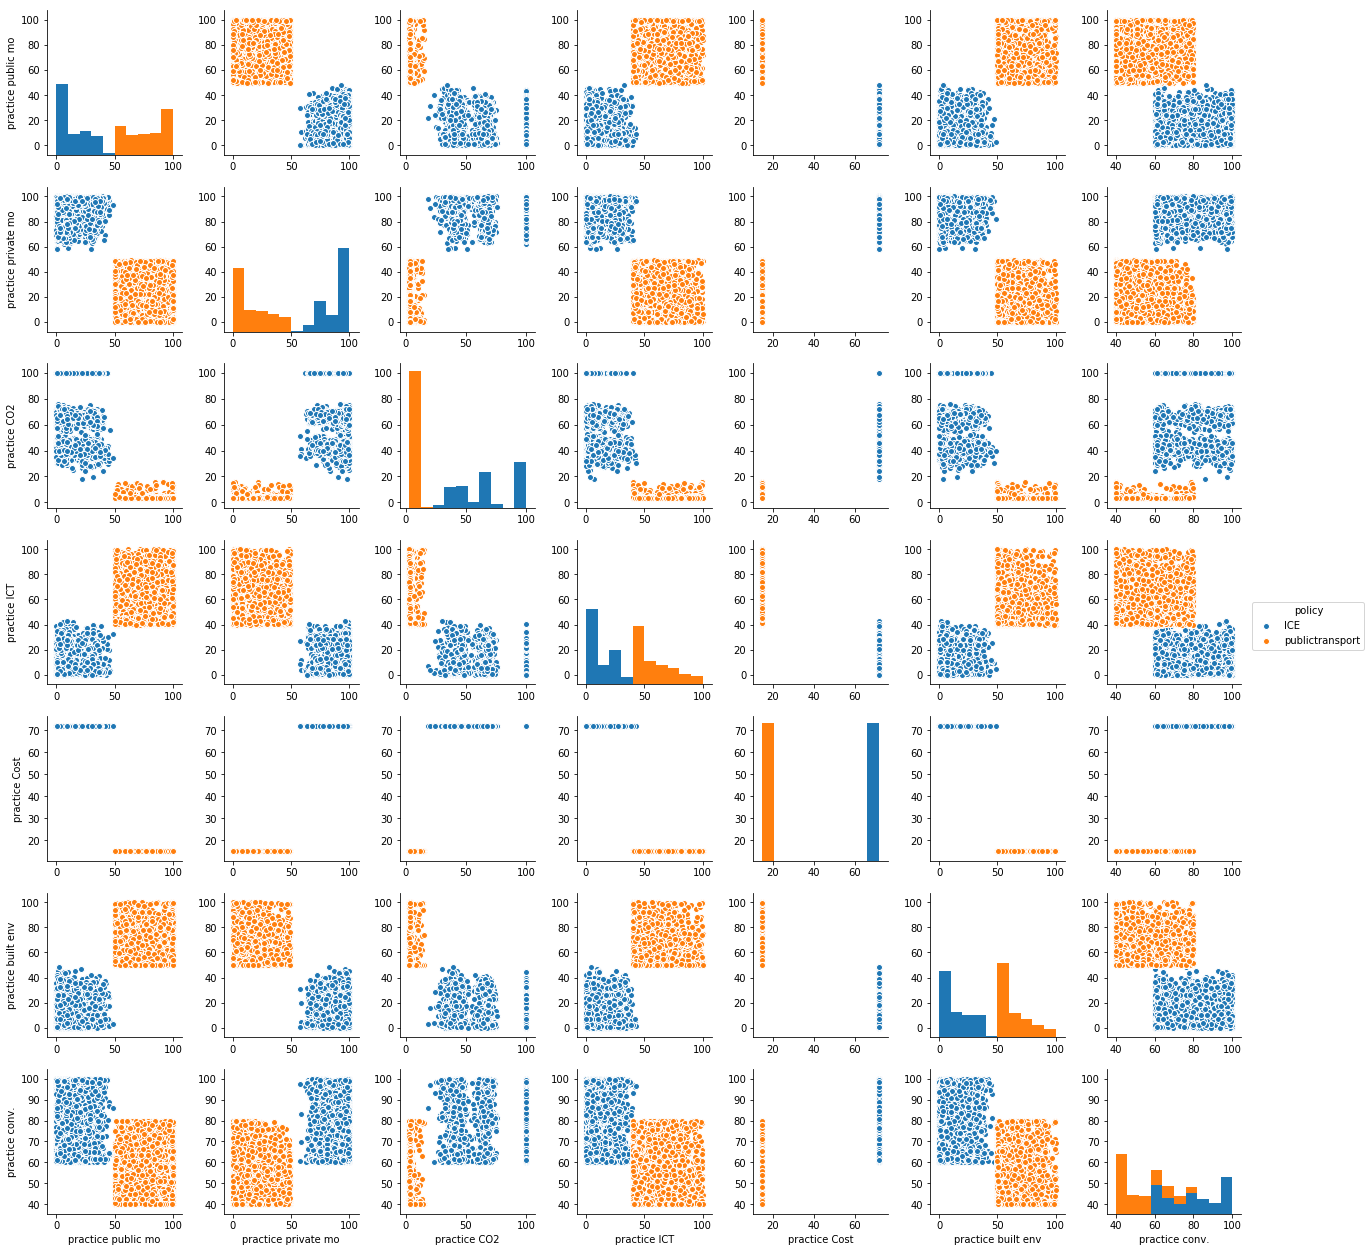

In [57]:
import seaborn as sns

experiments, outcomes = results

truncated_outcomes = { outcomes_key: outcomes[outcomes_key][:, -1] for outcomes_key in ['practice CO2', 'practice Cost', 'practice private mo', 'practice ICT', 
                        'practice built env', 'practice public mo', 'practice conv.'] }

df = pd.DataFrame.from_dict(truncated_outcomes)
df = df.assign(policy=experiments['policy'])


# rename the policies using numbers
#df['policy'] = df['policy'].map({p:i for i, p in
                                #enumerate(set(experiments['policy']))})
 
#use seaborn to plot the dataframe
grid = sns.pairplot(df, hue='policy',hue_order=['ICE', 'publictransport'],  vars=truncated_outcomes.keys())
ax = plt.gca()
plt.show()


In [ ]:
experiments, outcomes = results

ooi = 'number supporter'
data = outcomes[ooi] 

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)

truncated_outcomes = out[exp['policy'] == 'publictransport'].values

threshold = .5
indices = np.argmax(truncated_outcomes > threshold, axis=1)

logical= np.max(truncated_outcomes, axis=1) > threshold
indices = indices[logical]

time = outcomes['time'][0,:]
time = time[indices]

## Scenario discovery

In [89]:
#truncate experiments and outcomes for a selected policy and a selected outcome in a timestep


experiments, outcomes = results

policies_list = np.unique(experiments['policy'])

uncertainties = ['directioncarMIV', 'directioncarOEV', 'directioncarICT', 'directioncarBuildenv', 
                 'directioncarCO2', 'directioncarCost', 'directioncarConv']
                     
nexp_policy = len(experiments)/len(policies_list)

truncated_exp = np.zeros(nexp_policy, dtype={'names':uncertainties, 'formats':['float64']*len(uncertainties)})
    
        
for i in range(nexp_policy):
    l = []
    for j, uncertainty in enumerate(uncertainties):
        cell = experiments[i][j]
        l.append(cell)
    unc_set = tuple(l)
    truncated_exp[i] = unc_set

    
ooi = 'number supporter'
data = outcomes[ooi] 

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)

truncated_outcomes = out[exp['policy'] == 'publictransport'].values
truncated_outcomes_timeslice = truncated_outcomes [:, 20]

In [30]:
from ema_workbench.analysis import prim
 
 
x = truncated_exp
y = truncated_outcomes_timeslice > .5

prim_alg = prim.Prim(x, y, threshold=.5, threshold_type=1)
box1 = prim_alg.find_box()



NameError: name 'truncated_exp' is not defined

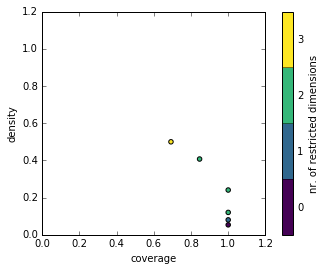

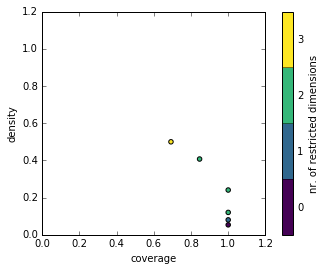

In [100]:
%matplotlib inline

box1.show_tradeoff()



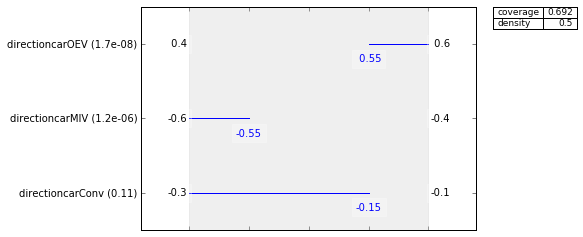

In [102]:
%matplotlib inline

box_1 = box1.inspect(5, style='graph')



## Dimensional stacking

In [86]:
#truncate experiments and outcomes for a selected policy and a selected outcome in a timestep


experiments, outcomes = results

policies_list = np.unique(experiments['policy'])

uncertainties = ['directioncarMIV', 'directioncarOEV', 'directioncarICT', 'directioncarBuildenv', 
                 'directioncarCO2', 'directioncarCost', 'directioncarConv']
                     
nexp_policy = len(experiments)/len(policies_list)

truncated_exp = np.zeros(nexp_policy, dtype={'names':uncertainties, 'formats':['float64']*len(uncertainties)})
    
        
for i in range(nexp_policy):
    l = []
    for j, uncertainty in enumerate(uncertainties):
        cell = experiments[i][j]
        l.append(cell)
    unc_set = tuple(l)
    truncated_exp[i] = unc_set

    
ooi = 'number supporter'
data = outcomes[ooi] 

exp = pd.DataFrame(experiments)
out = pd.DataFrame(data)

truncated_outcomes = out[exp['policy'] == 'publictransport'].values
truncated_outcomes_timeslice = truncated_outcomes [:, 20]

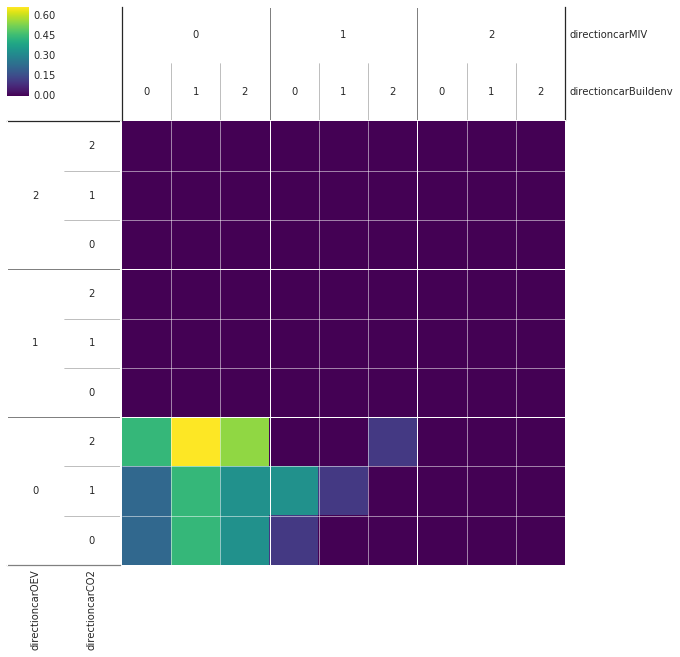

In [87]:
from ema_workbench.analysis import dimensional_stacking_2


x = truncated_exp
y = truncated_outcomes_timeslice > .5

dimensional_stacking_2.create_pivot_plot(x,y, nr_levels=2 ,nbins=3)
plt.show()

## Feature scoring

In [20]:
results = experiments, outcomes
ooilist = ['number supporter']

outcomes_scalar = {}

for ooi in ooilist:
    outcomes_scalar[ooi] = outcomes[ooi][:, -1]
    


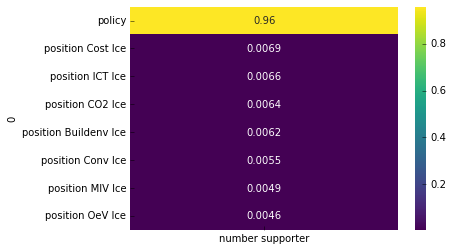

In [21]:
import seaborn as sns

from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes_scalar

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)

plt.show()

In [ ]:
%matplotlib inline

from __future__ import division
import csv

import scipy.stats as stats
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns

sns.set_style('white')

def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b                    
    return data


def make_kde(data):
    nr_points = 250
    grid = np.linspace(0, 1, nr_points)
    
    kde = stats.kde.gaussian_kde(data.T)
    x, y = np.meshgrid(grid, grid)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    z = kde(grid_coords.T)
    z = z.reshape(nr_points,nr_points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.flipud(z), cmap=cm.coolwarm)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig


def make_kde_scaled(class_data, full_data):
    nr_points = 250
    grid = np.linspace(0, 1, nr_points)
    
    x, y = np.meshgrid(grid, grid)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    
    kde_class = stats.kde.gaussian_kde(class_data.T)
    z_class = kde_class(grid_coords.T)
    z_class = z_class.reshape(nr_points,nr_points)
    
    kde_full = stats.kde.gaussian_kde(full_data.T)
    z_full = kde_full(grid_coords.T)
    z_full = z_full.reshape(nr_points,nr_points)

    # rescale
    class_max = np.max(z_class)
    loc = np.where(z_class==class_max)
    full_at_loc = z_full[loc]
    
    z_class = (full_at_loc/class_max ) * z_class
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.flipud(z_class), vmax=np.max(z_full), cmap=cm.coolwarm)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig


def make_parallel_plot(data, labels):

    fig = plt.figure()
    axes = []
    
    for i in range(1, data.shape[1]):
        ax = fig.add_subplot(1,data.shape[1]-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]])
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "1", va="bottom", ha="center")
        ax.text(i, -0.01, "0", va="top", ha="center")
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1])
    ax.text(i+1, 1.01, "1", va="bottom", ha="center")
    ax.text(i+1, -0.01, "0", va="top", ha="center")
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    plt.subplots_adjust(wspace=0)
    
    return fig, axes


def plot_data_parallel(data, labels, classes):
    C = set(classes)
    C = list(C)
    C.sort()
    
    norm_data = normalize(data)
    figures = []
    for index, Ci in enumerate(C):
        fig, axes = make_parallel_plot(data, labels)
        fig.suptitle('class {}'.format(Ci), fontsize=20)
        figures.append(fig)
        logical = classes==Ci
        
        for i,j in zip(range(data.shape[1]-1),range(1,data.shape[1])):
            ax = axes[i]
            y = norm_data[logical==False, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            ax.plot(x.T, y.T, c='#C0C0C0')
            
            y = norm_data[logical, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            ax.plot(x.T, y.T, c='b')
            
    return figures

In [ ]:
# three outputs of interest are selected here
import numpy as np


oois = ['number supporter', 'practice CO2', 'practice Cost']



data = np.array([[outcomes[oois[0]].mean(axis=1)[i], outcomes[oois[1]][:,-1][i], outcomes[oois[2]][:,-1][i]] 
                 for i in range(len(experiments))])
data = normalize(data)

In [ ]:
#Optimum number of clusters is chosen here based on two criteria. 
#The graph shows two criteria for the Bayesian Information Criterion (BIC) and Aikake's Information Criterion (AIC), 
#fitting a GMM over a range of 1 to 10 possible clusters.

from sklearn import mixture

aic = []
bic = []
max_components = 15
x = [x for x in range(1,max_components)]

for nc in x:
    g = mixture.GMM(n_components=int(nc), n_iter=500)
    g.fit(data)
    if g.converged_:
        aic.append(g.aic(data))
        bic.append(g.bic(data))
    else:
        aic.append(None)
        bic.append(None)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)
pca_data = normalize(pca_data)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, aic, label='AIC')
ax.plot(x, bic, label='BIC')
ax.legend(loc='best')
ax.set_xlabel('Components')

plt.show()

In [ ]:
n_clusters = 5

g = mixture.GMM(n_components=n_clusters, n_iter=500)
g.fit(data)
pred = g.predict(data)

In [ ]:
from ema_workbench.analysis.pairs_plotting import pairs_scatter


header = ['number supporter', 'practice CO2', 'practice Cost']

labels = {'SubsurfaceUse':'Fraction of subsurface used','number supporter':'number supporter', 
          'practice CO2':'practice CO2', 'practice Cost':'practice Cost' }
            
temp_outcomes = {header[i]:data[:, i] for i in range(len(header))}
temp_experiments = pred.astype(np.str).view([('classes', np.str)])

temp_results = temp_experiments, temp_outcomes

fig, axes = pairs_scatter(temp_results, group_by='classes',
                          grouping_specifiers=set(temp_experiments['classes']),
                          ylabels=labels,
                          filter_scalar=False)

fig.set_size_inches(15,15,forward=True)


#plt.savefig('{}/fig{}_highres.png'.format(r'W:\emoallemi@student.unimelb.edu.au 2017-09-13 08_19\My Library\UNSW\Publications\EM Experiment Design\Implementation\figs', 'scatter_full_quartile_041017'), 
            #dpi=300, bbox_inches='tight') 

plt.show()

## Connector file

In [ ]:
import sys
sys.path.append(r'W:\emoallemi@student.unimelb.edu.au 2017-09-13 08_19\My Library\UNSW\EMA\EMAworkbench-master_130118')

from ema_workbench.connectors import import_MATISSE_nopolicy


uncertainties = ['directioncarMIV', 'directioncarOEV', 'directioncarICT', 'directioncarBuildenv', 
                 'directiongreencarMIV', 'directiongreencarOEV', 'directiongreencarICT', 'directiongreencarBuildenv', 
                 'directionslowMIV', 'directionslowOEV', 'directionslowICT', 'directionslowBuildenv', 
                 'directionpublicMIV', 'directionpublicOEV', 'directionpublicICT', 'directionpublicBuildenv']


outcomes_of_interest = ['state', 'number supporter', 'strength', 
                        'practice CO2', 'practice Cost', 'practice private mo', 'practice ICT', 
                        'practice built env', 'practice public mo', 'practice conv.', 
                        'direction CO2', 'direction Cost', 'direction private mo', 'direction ICT', 
                        'direction built env', 'direction public mo', 'direction conv.']

policies = [{'name':'bev', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\bev'}, 
            {'name':'biofuel', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\biofuel'}, 
            {'name':'carshare', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\carshare'}, 
            {'name':'hybrid', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\hybrid'}, 
            {'name':'hydrogen', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\hydrogen'}, 
            {'name':'ICE', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\ICE'}, 
            {'name':'publictransport', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\publictransport'}, 
            {'name':'slowmodes', 
             'file':r'\\Mac\Home\Desktop\MATISSEDatabase\slowmodes'}]

number_of_experiments = 147

x = import_MATISSE_nopolicy.ImportfromMATISSE(uncertainties, outcomes_of_interest, policies, number_of_experiments)

results = x.extract_results()

